**Demonstration of Pólya-Gamma data augmentation scheme to do logistic regression.**

We simulate a spiking retinal neuron that's being illuminated with a variable intensity light.  We control the light, and observe the spikes.  

We model the probability of observing a spike $s_n =1$ (or not $s_n = 0$) in time bin $n$ by
$$
\begin{align}
p(s_n | I_n, \beta, \mu) = & \frac{\exp(\beta I_n + \mu)^{s_n}}{1 + \exp(\beta I_n + \mu)}
\end{align}.
$$

The model parameters here are $\beta$ and $\mu$.

The firing rate at time bin $n$ is approximately $\lambda_n = \frac{p(s_n = 1 | I_n, \beta, \mu)}{\Delta t}$, $\Delta t$ the bin size.  The posterior is then 
$$
\begin{align}      %%%%%%%%
p(\beta, \mu | \mathbf{I}, \mathbf{s}) \propto \prod_n p(s_n | I_n, \beta, \mu) p(\beta, \mu),
\end{align}
$$
where $p(\beta, \mu)$ is a prior - we further assume $p(\beta, \mu) = p(\beta)p(\mu)$.  Multiplying this by the prior $(\beta)$ or $p(\mu)$, this turns into the posterior distribution of $\beta$ or $\mu$.  This distribution can be sampled from using brute force by calculating the unnormalized probability for each discretized value of $\beta$ (or $\mu$).  But for spiking data, each $\beta$ value requires calculating a product of $N$ (bins) terms, one for each time bin and spike (0 or 1), and this needs to be calculated for a range of values of $\beta$ or $\mu$.  This is very expensive, since this must be done for each Gibbs iteration, and Gibbs typically might require several thousand iterations, so Polson et al (2013) developed a mathematical trick that introduces another random variable called the P\'olya-Gamma that makes this sampling much more tractable.  

In [1]:
###  First, clone the pyPG package from Github.  This will only last for this runtime session.  Do this every time you re-open notebook.
!git clone https://github.com/AraiKensuke/pyPG.git
%cd /content/pyPG/

###  pyPG is written in C++/python, and uses the C library GNU Scientific Library.  
!sudo apt-get install libgsl-dev   

###  setup and build pyPG
!python setup.py build_ext --inplace

Cloning into 'pyPG'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 90 (delta 2), reused 6 (delta 2), pack-reused 81
Unpacking objects: 100% (90/90), done.
/content/pyPG
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libgsl23 libgslcblas0
Suggested packages:
  gsl-ref-psdoc | gsl-doc-pdf | gsl-doc-info | gsl-ref-html
The following NEW packages will be installed:
  libgsl-dev libgsl23 libgslcblas0
0 upgraded, 3 newly installed, 0 to remove and 11 not upgraded.
Need to get 1,926 kB of archives.
After this operation, 9,474 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgslcblas0 amd64 2.4+dfsg-6 [79.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgsl23 amd64 2.4+dfsg-6 [823 kB]
Get:3 http://archive.ubuntu.com/u

First, we sample $\mathbf{\mu}$
$$
\begin{align}
p(\mu | \beta, \mathbf{I}, \mathbf{\omega}, \mathbf{s}) \propto &
\exp\left[-\sum\frac{\omega_n}{2} \left(\mu + \beta I_n - \frac{\kappa_n}{\omega_n}\right)^2 \right] N(\mu | \mu_{\mu}, \sigma^2_{\mu})
\nonumber\\
= &
\exp\left\{-\sum\frac{\omega_n}{2} \left[\mu - \left(\frac{\kappa_n}{\omega_n} - \beta I_n\right)\right]^2 \right\} N(\mu | \mu_{\mu}, \sigma^2_{\mu})
\nonumber \\
= &
N\left(\mu \left| \frac{\sum\frac{\omega_n}{2}\left(\frac{\kappa_n}{\omega_n} - \beta I_n\right)}{\sum\frac{\omega_n}{2}}, \frac{1}{\sum\omega_n}\right.\right) N(\mu | \mu_{\mu}, \sigma^2_{\mu}),
\end{align}
$$
which is Gaussian distributed.  Similar for $\beta$.

The following scipt makes some sample spiking data and a sinusoidal intensity signal that elicits the spikes.  We then fit a logistic model to the spike train, and infer the parameters $\mu$ and $\beta$.


In [2]:
import numpy as _N
import matplotlib.pyplot as _plt
import pyPG        #  Polya-Gamma sampler

T     = 30         #  length of experiment (in seconds)
N     = 10000      #  number of observations
dt    = T/N
ITERS = 2000       #  number of Gibbs iterations

t = _N.linspace(0, T, N, endpoint=False)
I = 0.5*(1+_N.sin(2*_N.pi*t))+0.01   #  normalized light intensity.  0.01 because we can't have 0 as a covariate (divide by 0 error)
#  We assume firing rate of neuron is directly proportional to intensity
fr= 25*I   #  

thr = _N.random.rand(N)

#  Generate spikes driven by light
spk01 = _N.zeros(N)
spk01[_N.where(thr < fr*dt)[0]] = 1

#  Our spiking data is spk01
#  Our known covariate is I.
#  do Bayesian logistic regression using Polya-Gamma data augmentation

#  p(s=1) = exp(BI + u) / (1 + exp(BI + u))
#  sample B, u

k     = spk01 - 0.5   #  kappa 

#  Initialize parameters  (to be updated via Gibbs sampling)
w     = _N.random.rand(N)     #  intial value
u     = _N.random.randn()
B     = _N.random.randn()

smps  = _N.empty((ITERS, 2))   #  let's keep the sampled values of u and B


#  priors for u, B     mean and variance  (we assume Gaussian priors on these)
_mu_u    = 0
_s2_u    = 5
_mu_B    = 0
_s2_B    = 5

#  Gibbs sampling
for itr in range(ITERS):
  kw    = k/w       #  we use this a lot
  kwI   = k/(w*I)       #  we use this a lot  

  #  sample u
  sw    = _N.sum(w)
  Mu    = _N.sum(w*(kw - B*I)) / sw
  Su    = 1/sw
  smpM  = (Mu*_s2_u + _mu_u * Su) / (_s2_u + Su)    #  mean of sampling distribution
  smpV  = (_s2_u * Su) /  (_s2_u + Su)
  u     = smpM + _N.sqrt(smpV)*_N.random.randn()  
  smps[itr, 0] = u

  #  sample B
  swI2  = _N.sum(w*I*I)
  MB    = _N.sum(w*I*I*(kwI - u/I)) / swI2
  SB    = 1/swI2
  smpM  = (MB*_s2_B + _mu_B * SB) / (_s2_B +SB)
  smpV  = (_s2_B * SB) /  (_s2_B + SB)
  B     = smpM + _N.sqrt(smpV)*_N.random.randn()
  smps[itr, 1] = B

  #  sample Polya Gamma random variables
  pyPG.rpg_devroye(1, u + I*B, out=w)   # output N samples


So now we've done the Gibbs sampling.  Let's take a look at the samples we got.

Text(0.5, 0, 'Beta')

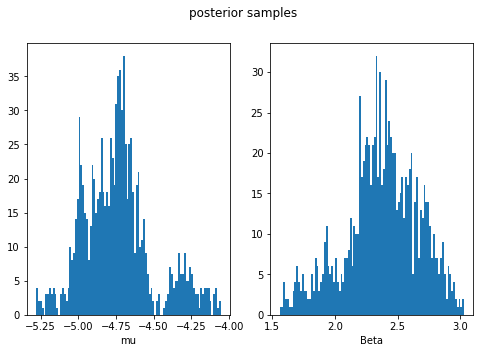

In [ ]:
fig = _plt.figure(figsize=(8, 5))
_plt.suptitle("posterior samples")
fig.add_subplot(1, 2, 1)
out = _plt.hist(smps[ITERS//2:, 0], bins=100)
_plt.xlabel("mu")
fig.add_subplot(1, 2, 2)
out = _plt.hist(smps[ITERS//2:, 1], bins=100)
_plt.xlabel("Beta")

Just for fun, let's look at the joint samples

Text(0, 0.5, 'Beta')

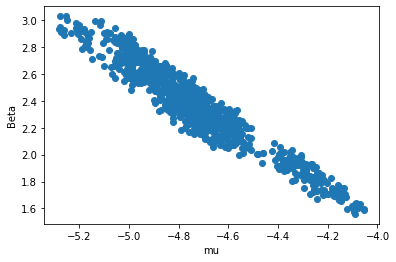

In [ ]:
fig = _plt.figure()
_plt.scatter(smps[ITERS//2:, 0], smps[ITERS//2:, 1])
_plt.xlabel("mu")
_plt.ylabel("Beta")

Now let's plug the parameters into the model, and compare it to ground truth firing rate.

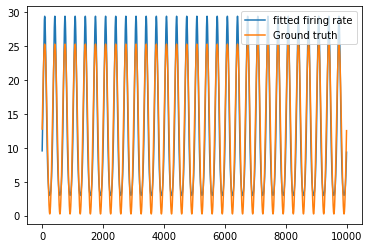

In [ ]:
mn_u = _N.mean(smps[ITERS//2:, 0])       #  mean of posterior samples
mn_B = _N.mean(smps[ITERS//2:, 1])       #  mean of posterior samples

_plt.plot((_N.exp(mn_u+I*mn_B) / (1 + _N.exp(mn_u+I*mn_B))) / dt, label="fitted firing rate")
_plt.plot(fr, label="Ground truth")
_plt.legend()